# Capstone Project workbook - Allie Garrison


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [ ]:
rt_reviews.head()

In [ ]:
rt_reviews.info()

In [ ]:
bom_movie_gross.info()

In [ ]:
bom_movie_gross.head()

In [ ]:
rt_movie_info.info()

In [ ]:
rt_movie_info.head()

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.head()

In [ ]:
tn_movie_budgets.info()

In [ ]:
tn_movie_budgets.head()

In [ ]:
tn_movie_budgets.plot.bar('production_budget')

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## keeping only the movies released after January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## removing all the movies that made $0
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [4]:
## Calculating return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317.0,620.181382,1316.721747,195.640815,415.369636
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220",306.0,936.662225,2053.311220,306.098766,671.016739


In [ ]:
q = '''
SELECT *
FROM persons
LEFT JOIN known_for k USING (person_id)
LEFT JOIN movie_basics m USING (movie_id)

'''

pd.read_sql(q, conn)

In [ ]:
pd.read_sql('''
SELECT  genres, COUNT() AS count_of_genres
FROM movie_basics
GROUP BY genres
ORDER BY count_of_genres DESC
''', conn)

In [ ]:
table3 = pd.read_sql('''
SELECT  title
FROM movie_akas
WHERE is_original_title = 1

''', conn)

### 

In [ ]:
## Joining the cleaned budget dataframe onto a queried dataframe from sql database on movie title
budget_w_sql = tn_movie_budgets_clean.merge(table3, how='inner', left_on='movie', right_on='title')

In [ ]:
budget_w_sql.describe()

In [5]:
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [6]:
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [ ]:
genre_ratings_budget.head(15)

In [ ]:
genre_ratings_budget.describe()

In [ ]:
genre_ratings_budget.runtime_minutes.plot.box()

In [ ]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Drama') == True]
avg_rating = genre_ratings_budget['averagerating'].mean()
avg_rating, action['averagerating'].mean()

In [ ]:
stats.ttest_1samp(action['averagerating'], popmean=avg_rating)

In [ ]:
genre_ratings_budget.genres.describe()

In [9]:
genre_ratings_budget['profit_in_millions'] = genre_ratings_budget['worldwide_gross_in_millions'] - genre_ratings_budget['production_budget_in_millions']

In [10]:
# genre_hash is a dictionary where each key is a genre, and the value is the number of times it occurs in the 'genres' column
genre_hash = {}

# array of lists where each individual list is every genre listed for a single movie
genre_lists = genre_ratings_budget['genres'].str.split(',')

for i, genres in enumerate(genre_lists):
    # try/ except in case there is an empty list (no genres listed for a movie)
    try:
        for genre in genres:
            # add one to genre if the key exists
            if genre in genre_hash.keys():
                genre_hash[genre] += 1
            # otherwise create the key
            else:
                genre_hash[genre] = 1
    except:
        pass

In [11]:
genre_stats = []
for genre in genre_hash.keys():
    #filter for every entry that contains the current genre
    mask = genre_ratings_budget[genre_ratings_budget['genres'].str.contains(genre) == True]
    # append list with averages for relevant features
    genre_stats.append([genre, mask['profit_in_millions'].mean().round(2), 
                        mask['production_budget_in_millions'].mean().round(2),
                        mask['averagerating'].mean().round(2),
                        mask['numvotes'].mean().round(2)])

In [12]:
#convert to dataframe
genre_stats_df = pd.DataFrame(genre_stats, 
                              columns=['Genre', 'Average_Profit', 'Average_Budget', 'Average_Rating', 'Average_Votes'])
genre_stats_df

,Genre,Average_Profit,Average_Budget,Average_Rating,Average_Votes
0,Action,160.90,79.93,6.33,173279.07
1,Adventure,241.02,105.76,6.49,195600.38
2,Fantasy,165.87,82.88,6.11,137905.34
3,Sci-Fi,236.87,88.97,6.49,258160.36
4,Thriller,82.10,34.26,6.05,105111.21
5,Western,46.35,50.07,6.78,165738.00
6,Animation,280.62,98.50,6.67,121386.85
7,Comedy,92.29,39.56,6.29,88686.08
8,Family,141.12,70.00,6.17,76245.96
9,Crime,50.29,32.38,6.39,106000.05


In [15]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Animation') == True]
avg_rating = genre_ratings_budget['profit_in_millions'].mean()
avg_rating, action['profit_in_millions'].mean()

(94.15790165165491, 280.6194115333333)

In [16]:
stats.ttest_1samp(action['profit_in_millions'], popmean=avg_rating)

Ttest_1sampResult(statistic=6.782217945321086, pvalue=7.403633429642129e-10)

In [17]:
animation = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Animation') == True]

<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

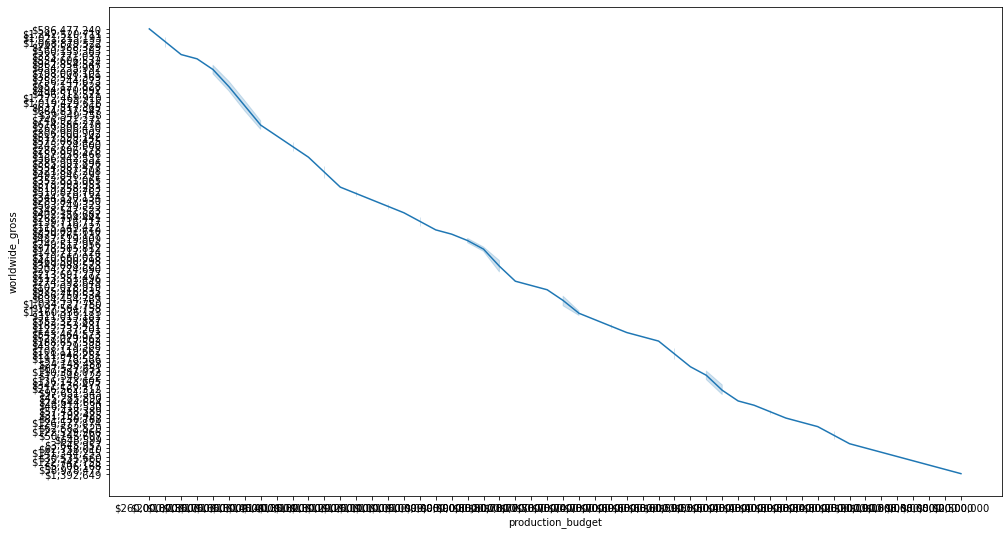

In [21]:
plt.figure(figsize=(16,9))
sns.lineplot(data = animation, x='production_budget', y='worldwide_gross')